In [14]:
import networkx as nx
from recsys_framework.graph.walker import *
from recsys_framework.data_manager.reader.Movielens100KReader import Movielens100KReader
import recsys_framework.graph.graph_builder as gbuilder
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

### Create the bipartite graph associated to M100K

In [2]:
reader = Movielens100KReader()
m100k_dataset = reader.load_data()
m100k_urm = m100k_dataset.get_URM()
m100k_graph = gbuilder.from_user_rating_matrix(m100k_urm)

100%|██████████| 1682/1682 [00:00<00:00, 1263851.55it/s]


reader: Loading /Users/edoardo/GitProjects/rsys/datasets/splits/Movielens100K/original/URM_all...
reader: Loading complete!
reader: Data loading and postprocessing completed
Current dataset is: Movielens100K
	Number of items: 1682
	Number of users: 943
	Number of interactions in URM_all: 100000
	Interaction density: 6.3047%
	Interactions per user:
		 Min: 20
		 Avg: 106.04
		 Max: 737
	Interactions per item:
		 Min: 1
		 Avg: 59.45
		 Max: 583

Adding users nodes...
Adding item nodes...


### Perform biased RWs

In [3]:
walker = UniformRandomWalker(m100k_graph)

walks = walker.run(
    nodes=list(m100k_graph.nodes()),  # root nodes
    length=100,  # maximum length of a random walk
    n=10,  # number of random walks per root node
    #p=0.5,  # Defines (unormalised) probability, 1/p, of returning to source node
    #q=2.0,  # Defines (unormalised) probability, 1/q, for moving away from source node
)
print("Number of random walks: {}".format(len(walks)))

100%|██████████| 2625/2625 [00:08<00:00, 296.72it/s]


Performing RWs...
Number of random walks: 26250


In [6]:
# Convert the integer ID to be string
walks_s = list(map(lambda x: list(map(str, x)), walks))

In [7]:
model = Word2Vec(walks_s, size=128, window=5, min_count=0, sg=1, workers=2, iter=1)


In [10]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index2word  # list of node IDs
node_embeddings = (
    model.wv.vectors
)  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = [m100k_graph.nodes[node_id]["kind"] for node_id in map(int,node_ids)]

In [12]:
# Apply t-SNE transformation on node embeddings
tsne = TSNE(n_components=2)
node_embeddings_2d = tsne.fit_transform(node_embeddings)

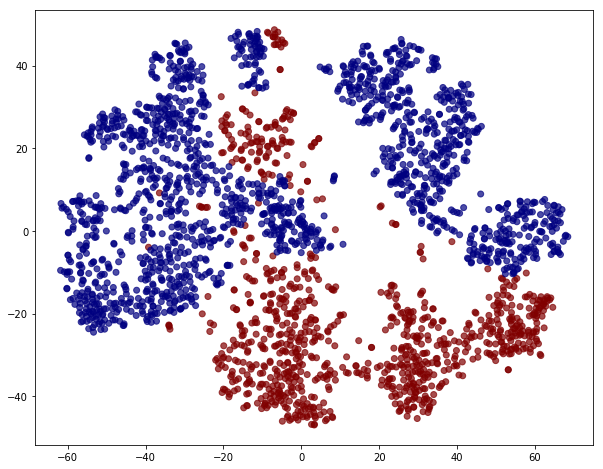

In [15]:
# draw the points
alpha = 0.7
label_map = {l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [label_map[target] for target in node_targets]

plt.figure(figsize=(10, 8))
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c=node_colours,
    cmap="jet",
    alpha=alpha,
)
